## Sentiment Analysis for 'TripAdvisor and Booking.com' Hotels Reviews

-----------------------------------------------------------------------------------------------------------

# Task 1 - Data Cleaning 

## 1.1 Import needed libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pycountry
from scipy.stats import chi2_contingency 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import re 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from textblob import TextBlob

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, log_loss
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,classification_report
import warnings
warnings.filterwarnings("ignore")

C:\Users\zaina\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\zaina\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\zaina\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## 1.2 Load dataset

In [2]:
# load dataset and save it in dataframe (df)
df = pd.read_csv("DS_fellowship_dataset.csv")
df = df.drop(df.columns[0], axis=1)  #drop the index column 
df

,reviewer_name,review_date,review,date_of_stay,trip_type,Hotel URL,City,Country
0,Pauline S,Nov 21,We had a wonderful time here. The food is deli...,November 2023,Traveled as a couple,https://www.tripadvisor.com/Hotel_Review-g7787...,Regensburg,Germany
1,kris,Nov 20,"my favorite holiday, with my wife. a great pla...",November 2023,Traveled as a couple,https://www.tripadvisor.com/Hotel_Review-g7787...,Sicily,Italy
2,Joanna,Nov 20,It is wanderfull płace. The staff is Very help...,November 2023,Traveled with family,https://www.tripadvisor.com/Hotel_Review-g7787...,NaN,NaN
3,Vermir M,Nov 17,Tonight we have our honeymoon Dinner By green ...,November 2023,Traveled as a couple,https://www.tripadvisor.com/Hotel_Review-g7787...,NaN,NaN
4,Curious49792382583,Nov 14,one of the best hotels I've ever been to. the ...,June 2023,Traveled with friends,https://www.tripadvisor.com/Hotel_Review-g7787...,NaN,NaN
...,...,...,...,...,...,...,...,...
2016,emanea482309,Feb 2023,"Clean and simple rooms,with air conditioining,...",January 2023,NaN,https://www.tripadvisor.com/Hotel_Review-g1631...,NaN,NaN
2017,dfurfa395674,Jan 2023,"we stayed for a period of 10 days, everything ...",December 2022,NaN,https://www.tripadvisor.com/Hotel_Review-g1631...,London,United Kingdom
2018,SDakaBabas,Jan 2023,The room was clean and had all amenities.\r\nT...,November 2022,Traveled solo,https://www.tripadvisor.com/Hotel_Review-g1631...,NaN,NaN
2019,dbucyi225654,Sep 2022,"Loved the rooms, the balcon that gave me extra...",September 2022,NaN,https://www.tripadvisor.com/Hotel_Review-g1631...,Kigali,Rwanda


## 1.3 Check duplicate rows

In [3]:
duplicate_rows = df[df.duplicated()]
print("Duplicate Rows:")
print(duplicate_rows)
#output = no duplication

Duplicate Rows:
Empty DataFrame
Columns: [reviewer_name, review_date, review, date_of_stay, trip_type, Hotel URL, City, Country]
Index: []


## 1.4 Check missing data

In [4]:
missing_data = df.isnull().sum()
print("Missing Data:")
print(missing_data)
#output = number of missing data in each column

Missing Data:
reviewer_name       0
review_date         0
review              0
date_of_stay        3
trip_type         291
Hotel URL           0
City              942
Country          1052
dtype: int64


### 1.4.1 Handdle 'date_of_stay' missing data

In [5]:
missing_date_of_stay = df[df['date_of_stay'].isnull()]

# visualize row
missing_info = missing_date_of_stay[['reviewer_name', 'review_date']]

# display the information of missing rows
print("Information for rows with missing date_of_stay:")
print(missing_info)

Information for rows with missing date_of_stay:
     reviewer_name review_date
1316      Marija S    Dec 2022
1470     said said    Jul 2023
1818      Elliot M    Apr 2022


#### - Preprocessing for 'date' information in dataset

In [6]:
'''
- convert the columns to string type to handle different formats of date
- we have 'review_date' and 'date_of_stay' columns that contains date
- parse_date function will check the date and split it to enable putting it in suitable date format
- date in this year 2024 appears without year ==> 2024 will added to it
- date in 1st of any month day not appear ==> day will added as 1st of that month
- we should cosider that some dates shortange name of month as 'Nov, Jun, ..' and some of them write it as full name 
- formats in data 'Nov 2022','November 2022','Nov 12', ..
'''
# convert to string to enable split and add
df['review_date'] = df['review_date'].astype(str)
df['date_of_stay'] = df['date_of_stay'].astype(str)

def parse_date(date_str):
    parts = date_str.split()  # split by space
    if len(parts) >= 2:  # check if at least two parts are present
        # check if month is abbreviated and the secound part contain year i.e. 'Nov 2022'
        if len(parts[0])==3 and len(parts[1])==4:  
            return pd.to_datetime(f'01-{parts[0]}-{parts[1]}', format='%d-%b-%Y', errors='coerce') #out: 01-11-2022
        # check if month is written full name i.e. 'November 2022'
        elif len(parts[0])>=4:
            return pd.to_datetime(f'01-{parts[0]}-{parts[1]}', format='%d-%B-%Y', errors='coerce') #out: 01-11-2022  
        # check if second part contain 1 or 2 digits (day) i.e. 'Nov 12','November 12'
        elif len(parts[1]) <= 2:  
            return pd.to_datetime(f'{parts[0]}-{parts[1]}-2024', format='%b-%d-%Y', errors='coerce') #out:12-11-2024
    else:
        return None 

# apply the function to both columns
df['review_date'] = df['review_date'].apply(parse_date)
df['date_of_stay'] = df['date_of_stay'].apply(parse_date)
df

,reviewer_name,review_date,review,date_of_stay,trip_type,Hotel URL,City,Country
0,Pauline S,2024-11-21,We had a wonderful time here. The food is deli...,2023-11-01,Traveled as a couple,https://www.tripadvisor.com/Hotel_Review-g7787...,Regensburg,Germany
1,kris,2024-11-20,"my favorite holiday, with my wife. a great pla...",2023-11-01,Traveled as a couple,https://www.tripadvisor.com/Hotel_Review-g7787...,Sicily,Italy
2,Joanna,2024-11-20,It is wanderfull płace. The staff is Very help...,2023-11-01,Traveled with family,https://www.tripadvisor.com/Hotel_Review-g7787...,NaN,NaN
3,Vermir M,2024-11-17,Tonight we have our honeymoon Dinner By green ...,2023-11-01,Traveled as a couple,https://www.tripadvisor.com/Hotel_Review-g7787...,NaN,NaN
4,Curious49792382583,2024-11-14,one of the best hotels I've ever been to. the ...,2023-06-01,Traveled with friends,https://www.tripadvisor.com/Hotel_Review-g7787...,NaN,NaN
...,...,...,...,...,...,...,...,...
2016,emanea482309,2023-02-01,"Clean and simple rooms,with air conditioining,...",2023-01-01,NaN,https://www.tripadvisor.com/Hotel_Review-g1631...,NaN,NaN
2017,dfurfa395674,2023-01-01,"we stayed for a period of 10 days, everything ...",2022-12-01,NaN,https://www.tripadvisor.com/Hotel_Review-g1631...,London,United Kingdom
2018,SDakaBabas,2023-01-01,The room was clean and had all amenities.\r\nT...,2022-11-01,Traveled solo,https://www.tripadvisor.com/Hotel_Review-g1631...,NaN,NaN
2019,dbucyi225654,2022-09-01,"Loved the rooms, the balcon that gave me extra...",2022-09-01,NaN,https://www.tripadvisor.com/Hotel_Review-g1631...,Kigali,Rwanda


One approach is to calculate the median time difference between the date of review and the date of stay, and then use this median time difference to impute missing date of stay values based on the date of review.

In [7]:
df1=df #copy dataframe 
# ensure about format of date for both columns
df1['review_date'] = pd.to_datetime(df1['review_date'], errors='coerce')
df1['date_of_stay'] = pd.to_datetime(df1['date_of_stay'], errors='coerce')

# filter out all data andd keep only data with non null, nan values
df1 = df1[(df1['review_date'].notnull()) & (df1['date_of_stay'].notnull())]

# calculate the time difference between review_date and date_of_stay for all data
df1['review_stay_diff'] = (df1['review_date'] - df1['date_of_stay']).dt.days

# calculate the median time difference
median_diff = df1['review_stay_diff'].median()
print('Median time difference between the date of review and the date of stay is ',median_diff) # print the median

Median time difference between the date of review and the date of stay is  0.0


- Bellow is visualization of distribution for time difference between review_date and date_of_stay for all data
- as seen  difference is the most common 

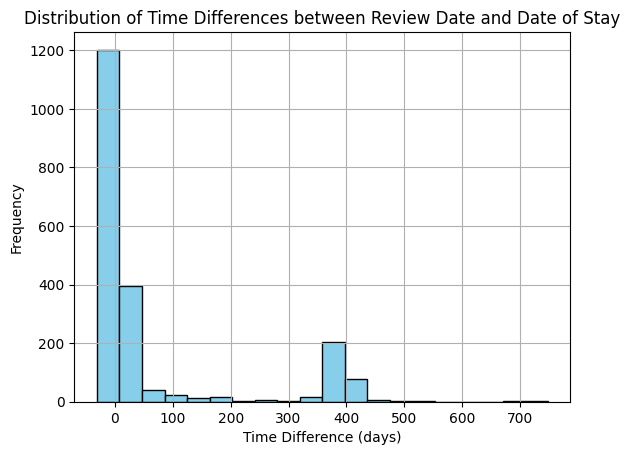

In [8]:
# visualize the time difference between review_date and date_of_stay for all data
plt.hist(df1['review_stay_diff'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Time Differences between Review Date and Date of Stay')
plt.xlabel('Time Difference (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

- Back to our main dataframe df and address the same review_date to the 3 missed date_of_stay data

In [9]:
'''
check if date_of_stay is null, 
if so equalize it with samme review_date of same row
then check the whole column
'''
for index, row in df.iterrows():
    if pd.isnull(row['date_of_stay']):
        df.at[index, 'date_of_stay'] = row['review_date']
        
# check if there are any None values left in the 'date_of_stay' column
print(df['date_of_stay'].isnull().sum())

0


In [10]:
print(df['date_of_stay'].iloc[1316], df['review_date'].iloc[1316]) 
# as we see the missing row in day_of_stay copied from its review_date info

2022-12-01 00:00:00 2022-12-01 00:00:00


- by checking missing data again it found that review_date have 5 missing data 
- after checking its index it found that review_date registered as 'reviewed yesterday' and with above code it converted to none when changing date format 'else:return None' 
- for that same above assumption will be applied for 5 missing data and make them equal to their day_of_stay info in same row

In [11]:
missing_data = df.isnull().sum()
print("Missing Data:")
print(missing_data)

Missing Data:
reviewer_name       0
review_date         5
review              0
date_of_stay        0
trip_type         291
Hotel URL           0
City              942
Country          1052
dtype: int64


In [12]:
# chek index of missing data from review_date and print it
missing_review_date = df[df['review_date'].isnull()]

# select relevant columns for visualization
missing_info = missing_review_date[['reviewer_name']]

# display the information
print("Information for rows with missing review_date:")
print(missing_info)

Information for rows with missing review_date:
        reviewer_name
640   Tour48187524128
943          Shemsa S
944         Salum Ali
1403           Cade W
1573        Samuele L


In [13]:
'''
check if  is null, 
if so equalize it with samme review_date of same row
then check the whole column
'''
for index, row in df.iterrows():
    if pd.isnull(row['review_date']):
        df.at[index, 'review_date'] = row['date_of_stay']

# check if there are any None values left in the 'review_date' column
print(df['review_date'].isnull().sum())


0


In [14]:
missing_data = df.isnull().sum()
print("Missing Data:")
print(missing_data)

Missing Data:
reviewer_name       0
review_date         0
review              0
date_of_stay        0
trip_type         291
Hotel URL           0
City              942
Country          1052
dtype: int64


### 1.4.2 Handdle 'trip_type' missing data

- for trip_type data, column information will be processed to be one word rather than scentence
travelled with family ==> family
- The choice of hotel often aligns with the purpose and preferences of a traveler's trip, shaping amenities, location, and overall guest experience for that, trip_type will be linked with hotel name in order to check the most trip_type in specific hotel and assign it to missing data

- ** Ref. task 2, 2.4 correlation matrix
**as shown the relationship between trip_type and hotel_name is logical as the review, review name is already unique for all. city - trip type gives also high relation but with considering that 942 missing data from cites it is not a wise option to group them together**

In [15]:
# extract the unique labels in trip_type column
unique_trip_types = df['trip_type'].unique()
unique_trip_types

array(['Traveled as a couple', 'Traveled with family',
       'Traveled with friends', 'Traveled on business', 'Traveled solo',
       nan], dtype=object)

In [16]:
'''
the function aim to replace the scentences in trip_type column to ease working with it
i.e. travelled with family ==> family and so on
then non defined ones assign nan 
'''
def map_trip_type(trip_type):
    if 'family' in trip_type.lower():
        return 'family'
    elif 'couple' in trip_type.lower():
        return 'couple'
    elif 'friends' in trip_type.lower():
        return 'friends'
    elif 'solo' in trip_type.lower():
        return 'solo'
    elif 'business' in trip_type.lower():
        return 'business'
    else:
        return np.nan 

# apply the function to the 'Trip Type' column
df['trip_type'] = df['trip_type'].astype(str) # change to string to ease mapping it
df['trip_type'] = df['trip_type'].apply(map_trip_type)

#### - Preprocessing 'Hotel URL' and extract new column hotel_name from it

In [17]:
df['hotel_name'] = df['Hotel URL'].str.split('-').str[-2].str.replace('_', ' ')
df

,reviewer_name,review_date,review,date_of_stay,trip_type,Hotel URL,City,Country,hotel_name
0,Pauline S,2024-11-21,We had a wonderful time here. The food is deli...,2023-11-01,couple,https://www.tripadvisor.com/Hotel_Review-g7787...,Regensburg,Germany,TUI BLUE Bahari Zanzibar
1,kris,2024-11-20,"my favorite holiday, with my wife. a great pla...",2023-11-01,couple,https://www.tripadvisor.com/Hotel_Review-g7787...,Sicily,Italy,TUI BLUE Bahari Zanzibar
2,Joanna,2024-11-20,It is wanderfull płace. The staff is Very help...,2023-11-01,family,https://www.tripadvisor.com/Hotel_Review-g7787...,NaN,NaN,TUI BLUE Bahari Zanzibar
3,Vermir M,2024-11-17,Tonight we have our honeymoon Dinner By green ...,2023-11-01,couple,https://www.tripadvisor.com/Hotel_Review-g7787...,NaN,NaN,TUI BLUE Bahari Zanzibar
4,Curious49792382583,2024-11-14,one of the best hotels I've ever been to. the ...,2023-06-01,friends,https://www.tripadvisor.com/Hotel_Review-g7787...,NaN,NaN,TUI BLUE Bahari Zanzibar
...,...,...,...,...,...,...,...,...,...
2016,emanea482309,2023-02-01,"Clean and simple rooms,with air conditioining,...",2023-01-01,NaN,https://www.tripadvisor.com/Hotel_Review-g1631...,NaN,NaN,Mocco Beach Villa
2017,dfurfa395674,2023-01-01,"we stayed for a period of 10 days, everything ...",2022-12-01,NaN,https://www.tripadvisor.com/Hotel_Review-g1631...,London,United Kingdom,Mocco Beach Villa
2018,SDakaBabas,2023-01-01,The room was clean and had all amenities.\r\nT...,2022-11-01,solo,https://www.tripadvisor.com/Hotel_Review-g1631...,NaN,NaN,Mocco Beach Villa
2019,dbucyi225654,2022-09-01,"Loved the rooms, the balcon that gave me extra...",2022-09-01,NaN,https://www.tripadvisor.com/Hotel_Review-g1631...,Kigali,Rwanda,Mocco Beach Villa


#### - Group hotel_name and trip_type

In [18]:
# group by hotel_name and trip_type and count occurrences
table_data = df.groupby(['hotel_name', 'trip_type']).size().unstack(fill_value=0)

# display the table that visualize the occurrences of trip_type for each hotel
table_data.head(10)


trip_type,business,couple,family,friends,solo
hotel_name,,,,,
AHG Waridi Beach Resort Spa,0,4,3,3,0
Airborne Kite Surf Village,0,4,0,2,2
Al Minar Hotel,2,4,2,0,2
Alladin Zanzibar,0,7,2,0,1
Alma Boutique Hotel,0,6,3,1,0
Aluna Nungwi,0,3,6,1,0
Aluna Paje,0,3,3,3,1
Amaan Beach Bungalows,0,2,1,3,2
Amani Boutique Hotel,0,5,2,1,1


#### - fill missing trip_type with the mode of it grouped with hotel name

In [19]:
# group by 'hotel_name' and fill missing trip types with the most frequent trip type for each hotel
df['trip_type'] = df.groupby('hotel_name')['trip_type'].transform(lambda x: x.fillna(x.mode().iloc[0]))


In [20]:
# check missing data
missing_data = df['trip_type'].isnull().sum()
print("Missing Data:")
print(missing_data)

Missing Data:
0


### 1.4.3 Handdle country/city missing data

In [21]:
# check rows with missing country but not missing city
missing_country_not_city = df[df['Country'].isnull() & df['City'].notnull()]
print("Rows with missing country but not missing city:")
missing_country_not_city

Rows with missing country but not missing city:


,reviewer_name,review_date,review,date_of_stay,trip_type,Hotel URL,City,Country,hotel_name
17,Armel T,2024-11-13,"heavenly stay, wonderful atmosphere, thanks to...",2023-09-01,couple,https://www.tripadvisor.com/Hotel_Review-g6160...,Cameroon,NaN,Hotel Riu Palace Zanzibar
20,Kamau,2024-11-19,"Lovely beds, breakfast covered well. Rooms sli...",2023-11-01,business,https://www.tripadvisor.com/Hotel_Review-g6160...,Kenya,NaN,Essque Zalu Zanzibar
69,Sabr,2023-09-01,I had a wonderful experience at the (Dongwe cl...,2022-09-01,family,https://www.tripadvisor.com/Hotel_Review-g6502...,Tanzania,NaN,Dongwe Club
79,Casey B,2023-10-01,This hotel was everything we wanted and more! ...,2023-09-01,couple,https://www.tripadvisor.com/Hotel_Review-g6160...,United Kingdom,NaN,Melia Zanzibar
82,konradszollosi,2024-11-21,We were looking for big peaceful resort with e...,2023-11-01,family,https://www.tripadvisor.com/Hotel_Review-g6160...,Hungary,NaN,Emerald Zanzibar Resort Spa
...,...,...,...,...,...,...,...,...,...
1846,hannah ashley,2023-07-01,We stayed last October after for a week after ...,2022-10-01,family,https://www.tripadvisor.com/Hotel_Review-g6357...,United Kingdom,NaN,Jambiani Villas
1851,DiariesofaBackpacker,2023-06-01,Our stay at the Jambiani villas was incredible...,2023-06-01,family,https://www.tripadvisor.com/Hotel_Review-g6357...,Miami,NaN,Jambiani Villas
1873,Jsheff,2023-09-01,We visited the Mangrove Lodge for our honeymoo...,2023-08-01,couple,https://www.tripadvisor.com/Hotel_Review-g8055...,Edmonton,NaN,Mangrove Lodge
1939,Erika F,2022-06-01,Relaxing week spent at the Waridi Beach resort...,2022-06-01,couple,https://www.tripadvisor.com/Hotel_Review-g7787...,United Kingdom,NaN,AHG Waridi Beach Resort Spa


- as noticed some of the cities are name of countries 
- bellow, city name is checked if it is 'country name' or not is so assign country name as same as city name

In [22]:
# get a list of known country names
country_names = [country.name for country in pycountry.countries]

# check if values in the "City" column are country names
city_is_country = missing_country_not_city['City'].isin(country_names)

# print rows where the city is a country name
missing_country_not_city[city_is_country]


,reviewer_name,review_date,review,date_of_stay,trip_type,Hotel URL,City,Country,hotel_name
17,Armel T,2024-11-13,"heavenly stay, wonderful atmosphere, thanks to...",2023-09-01,couple,https://www.tripadvisor.com/Hotel_Review-g6160...,Cameroon,NaN,Hotel Riu Palace Zanzibar
20,Kamau,2024-11-19,"Lovely beds, breakfast covered well. Rooms sli...",2023-11-01,business,https://www.tripadvisor.com/Hotel_Review-g6160...,Kenya,NaN,Essque Zalu Zanzibar
79,Casey B,2023-10-01,This hotel was everything we wanted and more! ...,2023-09-01,couple,https://www.tripadvisor.com/Hotel_Review-g6160...,United Kingdom,NaN,Melia Zanzibar
82,konradszollosi,2024-11-21,We were looking for big peaceful resort with e...,2023-11-01,family,https://www.tripadvisor.com/Hotel_Review-g6160...,Hungary,NaN,Emerald Zanzibar Resort Spa
86,Veronica,2024-11-21,Me and my Mom we had a wonderful experience in...,2023-11-01,family,https://www.tripadvisor.com/Hotel_Review-g6160...,Slovakia,NaN,Emerald Zanzibar Resort Spa
108,alonas11443,2023-02-01,"Great hotel, lovely staff, delicious food, did...",2023-02-01,couple,https://www.tripadvisor.com/Hotel_Review-g6663...,Ireland,NaN,Palumboreef Reef Beach Resort
148,Marc&Gerda,2023-08-01,It's really a place to relax in the nature. Qu...,2023-07-01,couple,https://www.tripadvisor.com/Hotel_Review-g1174...,Belgium,NaN,Zanzi Resort
176,Travel guy,2023-10-01,Booked a 2 week AI stay with TUI in July and w...,2023-07-01,couple,https://www.tripadvisor.com/Hotel_Review-g6357...,United Kingdom,NaN,Reef and Beach Resort
191,jomaloneLondon,2024-11-12,The surroundings are beautiful and the food wa...,2023-11-01,friends,https://www.tripadvisor.com/Hotel_Review-g1174...,United Kingdom,NaN,Sea Cliff Resort Spa
205,Shrdhi G,2023-09-01,My fiancé and I booked the luxury fruit villa ...,2023-08-01,couple,https://www.tripadvisor.com/Hotel_Review-g1355...,Malawi,NaN,Fruit Spice Wellness Resort


#### - copy all indices of rows that have city but the city name is country name and replace city name with ' '

In [23]:
country_indices = missing_country_not_city[city_is_country].index

# modify the DataFrame
df.loc[country_indices, 'Country'] = df.loc[country_indices, 'City']
#df.loc[country_indices, 'City'] = ''

In [24]:
# check missing data
missing_data = df.isnull().sum()
print("Missing Data:")
print(missing_data)

Missing Data:
reviewer_name      0
review_date        0
review             0
date_of_stay       0
trip_type          0
Hotel URL          0
City             942
Country          996
hotel_name         0
dtype: int64


- as shown, missing countries became 996 from 1052
- next step is to link all city and country provided in data together and make it as reference for our missing data 

In [25]:
df_cleaned = df.dropna(subset=['City', 'Country'])

# create the provided_data dictionary from the cleaned DataFrame
provided_data = dict(zip(df_cleaned['City'], df_cleaned['Country']))
provided_data

{'Regensburg': 'Germany',
 'Sicily': 'Italy',
 'Dubai': 'United Arab Emirates',
 'Sunderland': 'United Kingdom',
 'London': 'United Kingdom',
 'Zanzibar Island': 'Tanzania',
 'Cameroon': 'Cameroon',
 'Kenya': 'Kenya',
 'Hamburg': 'Germany',
 'Bengaluru': 'India',
 'Vienna': 'Austria',
 'Austrian Alps': 'Austria',
 'Colombo': 'Sri Lanka',
 'Tel Aviv': 'Israel',
 'Stockholm County': 'Sweden',
 'Gauteng': 'South Africa',
 'Stratford upon Avon': 'United Kingdom',
 'Zurich': 'Switzerland',
 'Pardubice': 'Czech Republic',
 'Istanbul': 'Türkiye',
 'Uijeongbu': 'South Korea',
 'Accra': 'Ghana',
 'Agbogba': 'Ghana',
 'Montreal': 'Canada',
 'Nottingham': 'United Kingdom',
 'Madrid': 'Spain',
 'Haywards Heath': 'United Kingdom',
 'Abidjan': 'Ivory Coast',
 'Doha': 'Qatar',
 'Okehampton': 'United Kingdom',
 'United Kingdom': 'United Kingdom',
 'Hungary': 'Hungary',
 'Slovakia': 'Slovakia',
 'Dar es Salaam': 'Tanzania',
 'Sheffield': 'United Kingdom',
 'Budapest': 'Hungary',
 'Ireland': 'Ireland',


In [26]:
# print rows where the 'Country' column is missing but the 'City' column is not missing
missing_country_not_city = df[df['Country'].isnull() & ~df['City'].isnull()]
missing_country_not_city


,reviewer_name,review_date,review,date_of_stay,trip_type,Hotel URL,City,Country,hotel_name
69,Sabr,2023-09-01,I had a wonderful experience at the (Dongwe cl...,2022-09-01,family,https://www.tripadvisor.com/Hotel_Review-g6502...,Tanzania,NaN,Dongwe Club
158,Jackie U,2023-09-01,We had three rooms here after our Serengeti sa...,2023-08-01,family,https://www.tripadvisor.com/Hotel_Review-g6160...,North Dakota,NaN,Nungwi Dreams by Mantis
184,LeicaM2,2023-08-01,This small boutique resort is arguably the\r\n...,2023-08-01,family,https://www.tripadvisor.com/Hotel_Review-g6160...,Piemonte,NaN,Mvuvi Boutique Resort
214,902johannam,2023-10-01,The Serena Zanzibar is simply the most beautif...,2023-10-01,friends,https://www.tripadvisor.com/Hotel_Review-g4881...,New York,NaN,Zanzibar Serena Hotel
327,Michael S,2024-11-01,My (now) wife and I chose Marijani for our wed...,2023-09-01,friends,https://www.tripadvisor.com/Hotel_Review-g7787...,Nairobi,NaN,LUX Marijani Zanzibar
350,ginauae,2023-10-01,We stayed there for a week. The atmosphere of ...,2023-10-01,family,https://www.tripadvisor.com/Hotel_Review-g6160...,dubai,NaN,Makofi Guest House
353,Mehmet,2023-09-01,"Perfect and friendly staff, location is a 10 a...",2023-09-01,solo,https://www.tripadvisor.com/Hotel_Review-g6160...,The Netherlands,NaN,Makofi Guest House
368,Jana K.Ch.,2023-03-01,We have already been to your place twice and w...,2023-03-01,family,https://www.tripadvisor.com/Hotel_Review-g4828...,Czech Republic,NaN,White Paradise Zanzibar
405,DMSLeicestershire,2023-09-01,This was the last leg of our 2 week tour with ...,2023-09-01,couple,https://www.tripadvisor.com/Hotel_Review-g6160...,Leicestershire,NaN,The Zanzibari
414,ladywendymoorcroft,2023-10-01,"WOW!!! Do not hesitate - go, go,go! The Palms ...",2023-09-01,couple,https://www.tripadvisor.com/Hotel_Review-g6160...,staffordshire,NaN,The Palms Zanzibar


- for missing_country_not_city and cities not a country name chatgpt used to get labeled city-country data to complete our dictionary of country-city and handdle missing data from it

In [27]:
manual_data = {
    'Tanzania': 'Tanzania',
    'North Dakota': 'United States',
    'Piemonte': 'Italy',
    'dubai': 'United Arab Emirates',
    'The Netherlands': 'Netherlands',
    'Czech Republic': 'Czechia',
    'Leicestershire': 'United Kingdom',
    'staffordshire': 'United Kingdom',
    'london': 'United Kingdom',
    'Europe': 'Europe',
    'Worldwide': 'Worldwide',
    'Scottsdale': 'United States',
    'Houilles': 'France',
    'worcester': 'United Kingdom',
    'new york city': 'United States',
    'New Jersey': 'United States',
    'texas': 'United States',
    'nyc': 'United States',
    'California': 'United States',
    'Agrigento': 'Italy',
    'Delhi': 'India',
    'Ohio': 'United States',
    'Płock': 'Poland',
    'Bergamo': 'Italy',
    'St. Lucia': 'Saint Lucia',
    'Naperville': 'United States',
    'Bay Area': 'United States',
    'NY': 'United States',
    'UK': 'United Kingdom',
    'Thule': 'Greenland',
    'Africa': 'Africa',
    'Miami': 'United States',
    'Edmonton': 'Canada',
    'tanzania': 'Tanzania',
    'Texas':'United States'
}

# Update provided_data with manual data
provided_data.update(manual_data)

- Time to handdle the missing data of cities/countries from our prepared dictionary
- other ready function can be used also as well

In [28]:
# identify rows with missing city or country
missing_rows = df[df['City'].isnull() | df['Country'].isnull()]

# loop through each row with missing data
for index, row in missing_rows.iterrows():
    city = row['City']
    country = row['Country']
    
    # when city is missing but country is provided
    if pd.isnull(city) and not pd.isnull(country):
        # fill city based on provided country
        for provided_city, provided_country in provided_data.items():
            if provided_country == country:
                df.at[index, 'City'] = provided_city
                break
    
    # if country is missing but city is provided
    elif not pd.isnull(city) and pd.isnull(country):
        # fill country based on provided city
        if city in provided_data:
            df.at[index, 'Country'] = provided_data[city]

In [29]:
missing_data = df.isnull().sum()
print("Missing Data:")
print(missing_data)

Missing Data:
reviewer_name      0
review_date        0
review             0
date_of_stay       0
trip_type          0
Hotel URL          0
City             942
Country          942
hotel_name         0
dtype: int64


- now, we got equal missed data for city/country 

## 1.5 Check the data type of all dataframe columns 

In [30]:
df.dtypes

reviewer_name            object
review_date      datetime64[ns]
review                   object
date_of_stay     datetime64[ns]
trip_type                object
Hotel URL                object
City                     object
Country                  object
hotel_name               object
dtype: object

------------------------------------------------

# Task 2 -  Exploratory Data Analysis (EDA)  

## 2.1 Temporal analysis of hotel reviews - yearly patterns

- as shown, most of reviews between 2023 -2024 and the reviews incresed after 2021 indicating that the travel industry refreshed after COVID-19

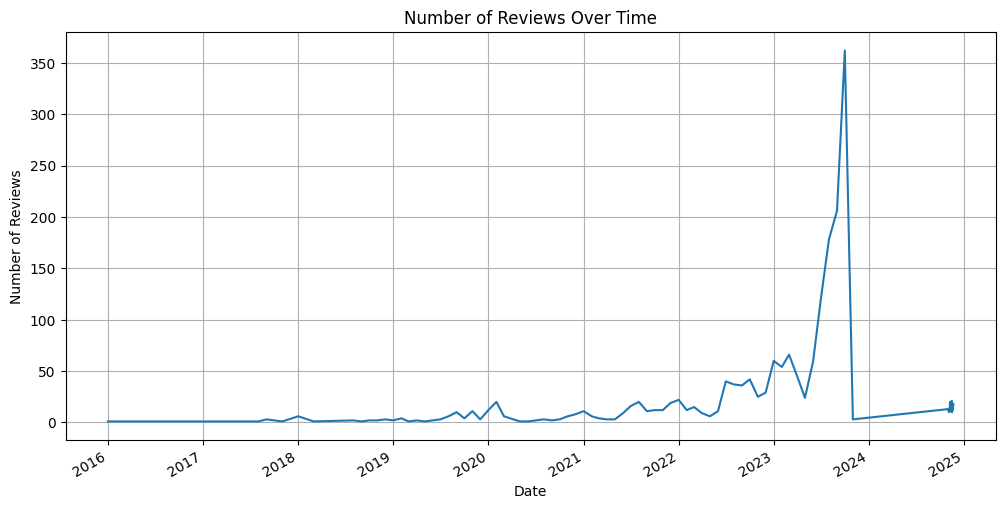

In [31]:
# Visualization for review_date through hotels
plt.figure(figsize=(12, 6))
df['review_date'] = pd.to_datetime(df['review_date'])
df['review_date'].value_counts().plot()
plt.title("Number of Reviews Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.show()

## 2.2  Visualization for trip_type 

- as shown most of trips for couples, families and friends

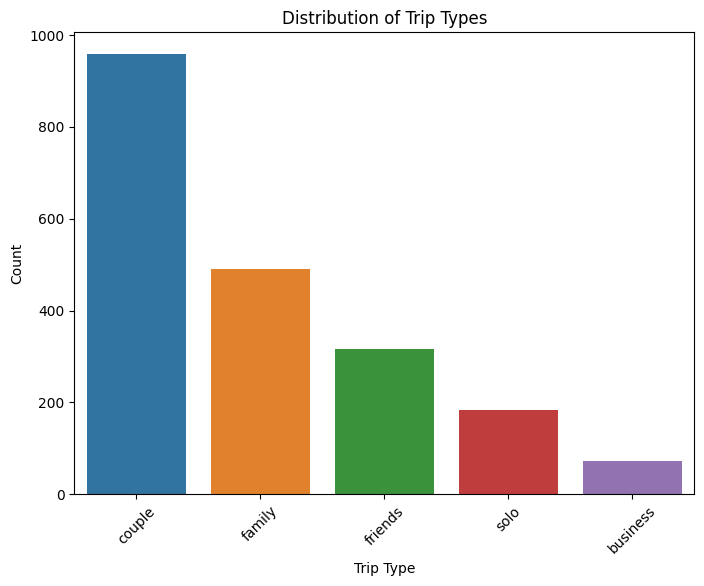

In [32]:
# Visualization for trip_type (categorical)
plt.figure(figsize=(8, 6))
sns.countplot(x='trip_type', data=df, order=df['trip_type'].value_counts().index)
plt.title("Distribution of Trip Types")
plt.xlabel("Trip Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## 2.3 Top 5 countries by number of reviews

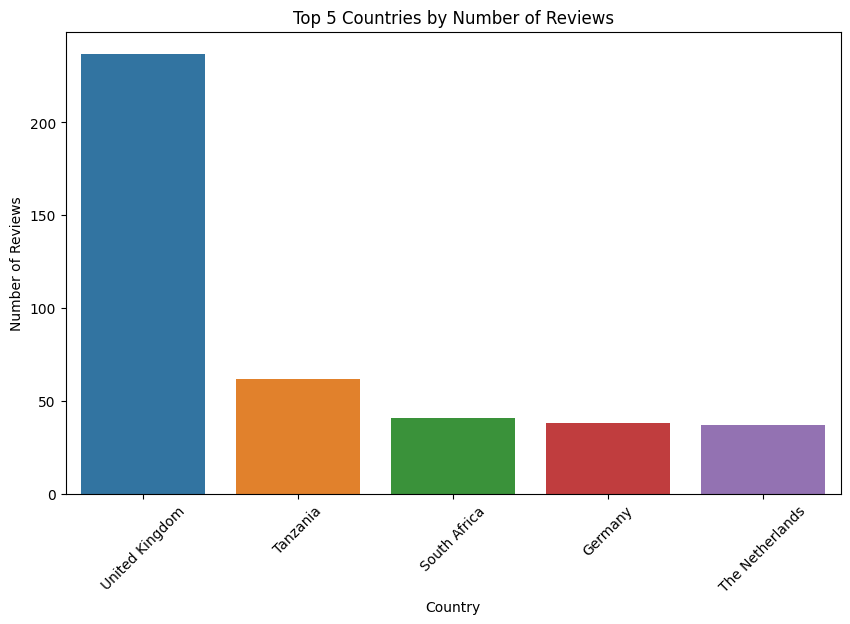

In [33]:

# Visualization for Country (Categorical)
plt.figure(figsize=(10, 6))
sns.countplot(x='Country', data=df, order=df['Country'].value_counts().index[:5])
plt.title("Top 5 Countries by Number of Reviews")
plt.xlabel("Country")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.show()



## 2.4 Categorical correlation heatmap for data

The benefit of a categorical correlation heatmap is to provide a clear visual representation of the relationships between categorical variables in the data, helping to identify patterns, dependencies, and associations that may not be immediately obvious from individual variables alone.

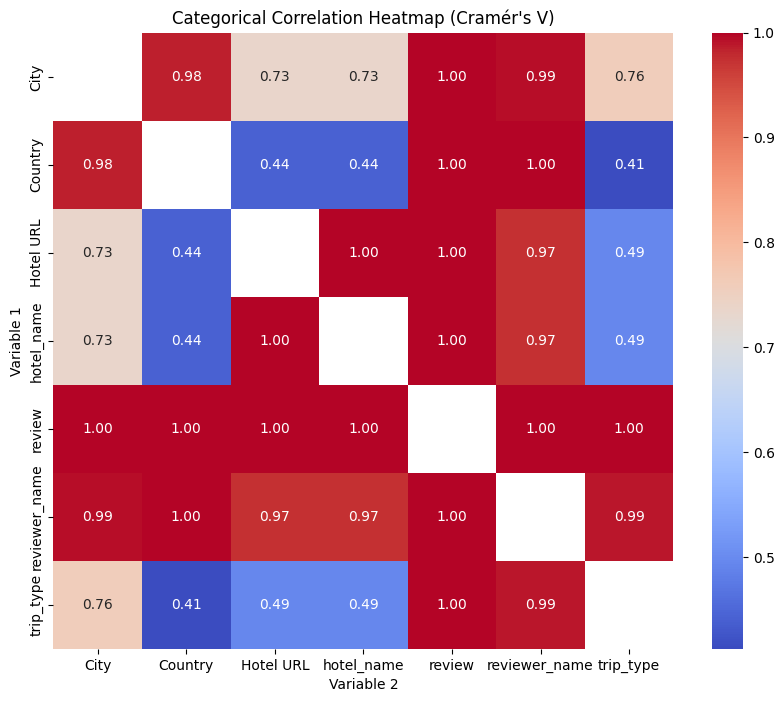

In [34]:
# select categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# create a contingency table for each pair of categorical variables
contingency_tables = []
for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 != col2:
            contingency_table = pd.crosstab(df[col1], df[col2])
            contingency_tables.append((col1, col2, contingency_table))

# calculate Cramér's V for each pair of categorical variables
cramer_vs = []
for col1, col2, table in contingency_tables:
    chi2 = chi2_contingency(table)[0]
    n = table.sum().sum()
    min_dim = min(table.shape) - 1
    cramer_v = np.sqrt(chi2 / (n * min_dim))
    cramer_vs.append((col1, col2, cramer_v))

# create a DataFrame for Cramér's V values
cramer_df = pd.DataFrame(cramer_vs, columns=['Variable 1', 'Variable 2', "Cramér's V"])

# pivot the DataFrame for visualization
heatmap_data = cramer_df.pivot(index='Variable 1', columns='Variable 2', values="Cramér's V")

# plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Categorical Correlation Heatmap (Cramér's V)")
plt.show()


- as shown the relationship between trip_type and hotel_name is logical as the review, review name is already unique for all. city - trip type gives also high relation but with considering that 942 missing data from cites it is not a wise option to group them together

## 2.5 Word cloud visualization 

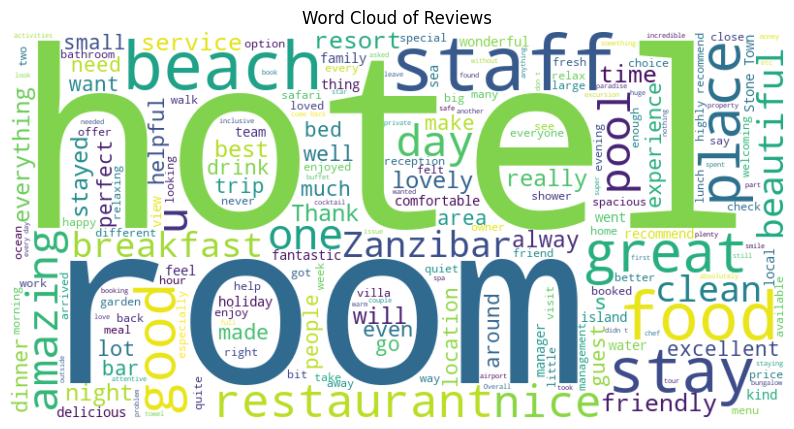

In [35]:
# visualization for review (Text)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['review']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud of Reviews")
plt.axis('off')
plt.show()

----------------------------------------------------------------------

# Task 3 - Keyword Extraction 

## 3.1 Clean review text data

In [36]:
'''
- in this step review data will be preprocessed, 
- convert all text to lower case, delete non-alphabetic stuff in addition to stop words
- then apply stemming and combine all text together to give clean "review" 
- TF-IDF applied to extract keywords
- new columns, cleaned review and keywords
'''
# initialize stopwords
stop_words = set(stopwords.words('english'))

# define preprocessing function
def preprocess_text(text):
    # convert text to lowercase
    text = text.lower()
    # remove non-alphabetic characters 
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)    
    # tokenize the text (split into words)
    words = text.split()
    # remove stop words
    words = [word for word in words if word not in stop_words]
    # perform stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    # join the words back into a single string
    processed_text = ' '.join(words)
    return processed_text

# apply preprocessing to the reviews
df['review_cleaned'] = df['review'].apply(preprocess_text)

# create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# fit the vectorizer to the cleaned reviews
tfidf_matrix = tfidf_vectorizer.fit_transform(df['review_cleaned'])

# extract keywords and key phrases
keywords = tfidf_vectorizer.get_feature_names_out()

# add a new column to the dataset with the extracted keywords
df['keywords'] = df['review_cleaned'].apply(lambda x: ', '.join([word for word in keywords if word in x]))
df

,reviewer_name,review_date,review,date_of_stay,trip_type,Hotel URL,City,Country,hotel_name,review_cleaned,keywords
0,Pauline S,2024-11-21,We had a wonderful time here. The food is deli...,2023-11-01,couple,https://www.tripadvisor.com/Hotel_Review-g7787...,Regensburg,Germany,TUI BLUE Bahari Zanzibar,wonder time food delici beach great staff kind...,"ac, beach, best, come, cool, delici, dri, drin..."
1,kris,2024-11-20,"my favorite holiday, with my wife. a great pla...",2023-11-01,couple,https://www.tripadvisor.com/Hotel_Review-g7787...,Sicily,Italy,TUI BLUE Bahari Zanzibar,favorit holiday wife great place romant time t...,"ac, beach, day, dri, drink, eat, everyth, exce..."
2,Joanna,2024-11-20,It is wanderfull płace. The staff is Very help...,2023-11-01,family,https://www.tripadvisor.com/Hotel_Review-g7787...,NaN,NaN,TUI BLUE Bahari Zanzibar,wanderful pace staff help kindli like paradis ...,"ac, ad, al, amaz, best, big, break, breakfast,..."
3,Vermir M,2024-11-17,Tonight we have our honeymoon Dinner By green ...,2023-11-01,couple,https://www.tripadvisor.com/Hotel_Review-g7787...,NaN,NaN,TUI BLUE Bahari Zanzibar,tonight honeymoon dinner green grill servic ms...,"al, ali, dinner, green, grill, honeymoon, ice,..."
4,Curious49792382583,2024-11-14,one of the best hotels I've ever been to. the ...,2023-06-01,friends,https://www.tripadvisor.com/Hotel_Review-g7787...,NaN,NaN,TUI BLUE Bahari Zanzibar,one best hotel ive ever food good nice room st...,"ac, activ, bar, best, end, especi, food, frien..."
...,...,...,...,...,...,...,...,...,...,...,...
2016,emanea482309,2023-02-01,"Clean and simple rooms,with air conditioining,...",2023-01-01,solo,https://www.tripadvisor.com/Hotel_Review-g1631...,NaN,NaN,Mocco Beach Villa,clean simpl roomswith air conditioiningon ocea...,"air, beauti, best, break, breakfast, car, care..."
2017,dfurfa395674,2023-01-01,"we stayed for a period of 10 days, everything ...",2022-12-01,solo,https://www.tripadvisor.com/Hotel_Review-g1631...,London,United Kingdom,Mocco Beach Villa,stay period day everyth fantast structur staff...,"ac, ad, beach, day, definit, everyth, fan, fan..."
2018,SDakaBabas,2023-01-01,The room was clean and had all amenities.\r\nT...,2022-11-01,solo,https://www.tripadvisor.com/Hotel_Review-g1631...,NaN,NaN,Mocco Beach Villa,room clean amen staff friendli polit hotel dir...,"ac, amen, bar, beach, beauti, cat, clean, dire..."
2019,dbucyi225654,2022-09-01,"Loved the rooms, the balcon that gave me extra...",2022-09-01,solo,https://www.tripadvisor.com/Hotel_Review-g1631...,Kigali,Rwanda,Mocco Beach Villa,love room balcon gave extra rooftop view hotel...,"ac, al, area, ate, bath, bathroom, beach, book..."


## 3.2 Visualize word map for cleaned review data

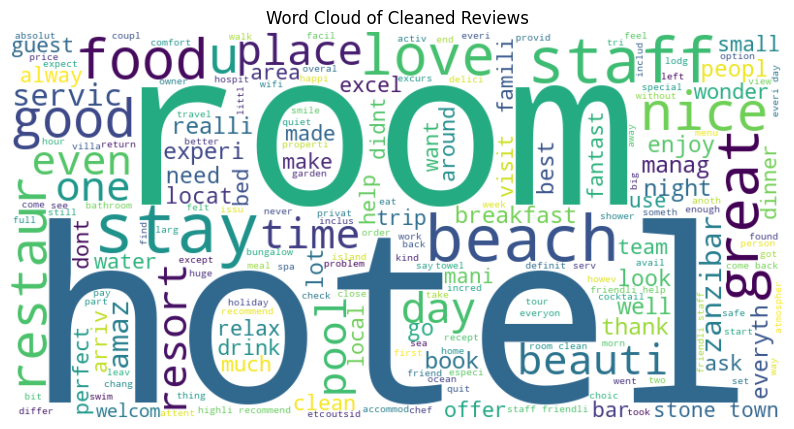

In [37]:
all_reviews = ' '.join(df['review_cleaned'])

# generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# plot
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Reviews')
plt.show()

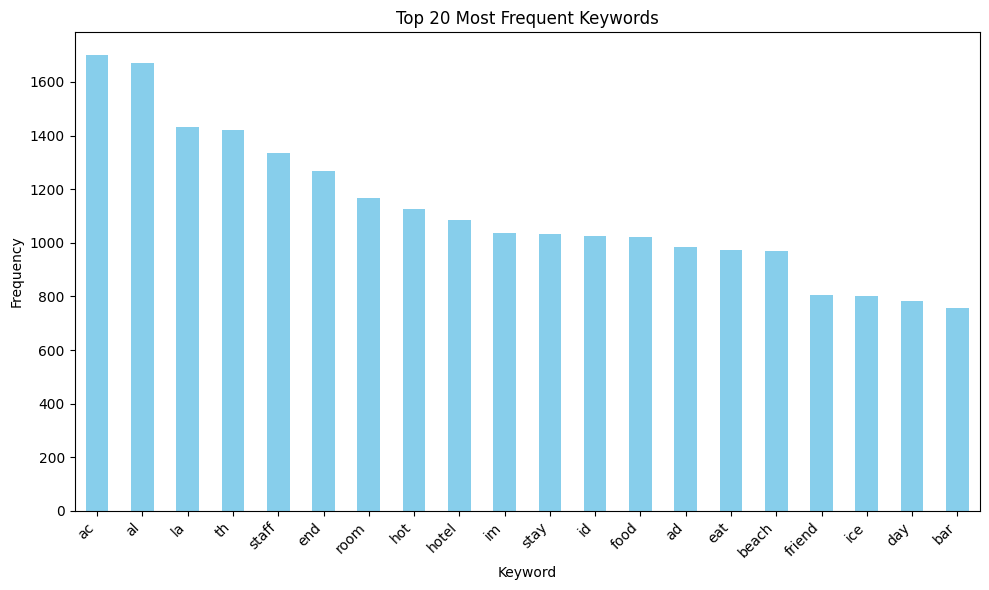

In [38]:
# count the frequency of each keyword
keyword_freq = df['keywords'].str.split(', ').explode().value_counts()

# plot
top_n = 20  
plt.figure(figsize=(10, 6))
keyword_freq.head(top_n).plot(kind='bar', color='skyblue')
plt.title(f'Top {top_n} Most Frequent Keywords')
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


------------------------------------------------------

# Task 4 - Sentiment Analysis 

## 4.1 Sentiment Labeling

In [39]:
# initializing the VADER sentiment analyzer
nltk.download('vader_lexicon')   
sia = SentimentIntensityAnalyzer()

# initializing lists to store sentiment labels and scores
sentiment_labels = []
sentiment_scores = []

# processing each review and perform sentiment analysis
for i in range(len(df)):  # Use range (0, 50)
    review = df['review_cleaned'][i]
    sentiment_score = sia.polarity_scores(review)['compound']
    
    # determining sentiment label based on sentiment score
    if sentiment_score > 0.6:
        sentiment_labels.append('Positive')
    elif sentiment_score < 0.2:
        sentiment_labels.append('Negative')
    else:
        sentiment_labels.append('Neutral')
    
    sentiment_scores.append(sentiment_score)

# creating a new DataFrame with the sentiment analysis results
sentiment_df = pd.DataFrame({
    'Sentiment_Label': sentiment_labels,
    'Sentiment_Score': sentiment_scores
})

# Concatenate df
df = pd.concat([df, sentiment_df], axis=1)

print("Sentiment Analysis Results:")
df 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\zaina\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Sentiment Analysis Results:


,reviewer_name,review_date,review,date_of_stay,trip_type,Hotel URL,City,Country,hotel_name,review_cleaned,keywords,Sentiment_Label,Sentiment_Score
0,Pauline S,2024-11-21,We had a wonderful time here. The food is deli...,2023-11-01,couple,https://www.tripadvisor.com/Hotel_Review-g7787...,Regensburg,Germany,TUI BLUE Bahari Zanzibar,wonder time food delici beach great staff kind...,"ac, beach, best, come, cool, delici, dri, drin...",Positive,0.9325
1,kris,2024-11-20,"my favorite holiday, with my wife. a great pla...",2023-11-01,couple,https://www.tripadvisor.com/Hotel_Review-g7787...,Sicily,Italy,TUI BLUE Bahari Zanzibar,favorit holiday wife great place romant time t...,"ac, beach, day, dri, drink, eat, everyth, exce...",Positive,0.9468
2,Joanna,2024-11-20,It is wanderfull płace. The staff is Very help...,2023-11-01,family,https://www.tripadvisor.com/Hotel_Review-g7787...,NaN,NaN,TUI BLUE Bahari Zanzibar,wanderful pace staff help kindli like paradis ...,"ac, ad, al, amaz, best, big, break, breakfast,...",Positive,0.9674
3,Vermir M,2024-11-17,Tonight we have our honeymoon Dinner By green ...,2023-11-01,couple,https://www.tripadvisor.com/Hotel_Review-g7787...,NaN,NaN,TUI BLUE Bahari Zanzibar,tonight honeymoon dinner green grill servic ms...,"al, ali, dinner, green, grill, honeymoon, ice,...",Positive,0.8481
4,Curious49792382583,2024-11-14,one of the best hotels I've ever been to. the ...,2023-06-01,friends,https://www.tripadvisor.com/Hotel_Review-g7787...,NaN,NaN,TUI BLUE Bahari Zanzibar,one best hotel ive ever food good nice room st...,"ac, activ, bar, best, end, especi, food, frien...",Positive,0.9559
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,emanea482309,2023-02-01,"Clean and simple rooms,with air conditioining,...",2023-01-01,solo,https://www.tripadvisor.com/Hotel_Review-g1631...,NaN,NaN,Mocco Beach Villa,clean simpl roomswith air conditioiningon ocea...,"air, beauti, best, break, breakfast, car, care...",Positive,0.9571
2017,dfurfa395674,2023-01-01,"we stayed for a period of 10 days, everything ...",2022-12-01,solo,https://www.tripadvisor.com/Hotel_Review-g1631...,London,United Kingdom,Mocco Beach Villa,stay period day everyth fantast structur staff...,"ac, ad, beach, day, definit, everyth, fan, fan...",Positive,0.8225
2018,SDakaBabas,2023-01-01,The room was clean and had all amenities.\r\nT...,2022-11-01,solo,https://www.tripadvisor.com/Hotel_Review-g1631...,NaN,NaN,Mocco Beach Villa,room clean amen staff friendli polit hotel dir...,"ac, amen, bar, beach, beauti, cat, clean, dire...",Positive,0.7783
2019,dbucyi225654,2022-09-01,"Loved the rooms, the balcon that gave me extra...",2022-09-01,solo,https://www.tripadvisor.com/Hotel_Review-g1631...,Kigali,Rwanda,Mocco Beach Villa,love room balcon gave extra rooftop view hotel...,"ac, al, area, ate, bath, bathroom, beach, book...",Neutral,0.4588


### Visualize Sentiment Distribution

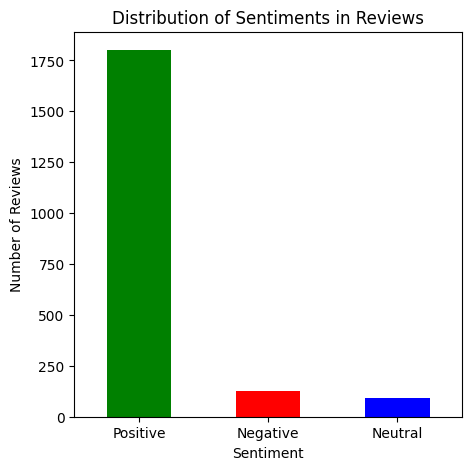

In [40]:
sentiment_counts = df['Sentiment_Label'].value_counts()

plt.figure(figsize=(5, 5))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Distribution of Sentiments in Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()


### Distribution of Sentiment Scores

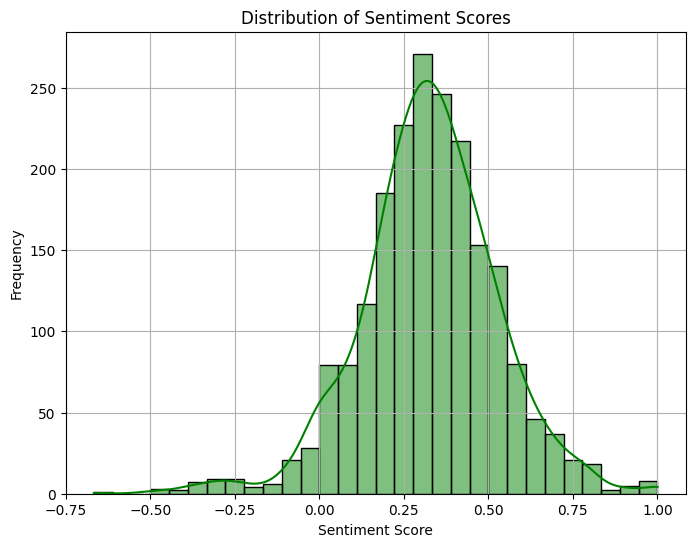

In [41]:
df['Sentiment_Score'] = df['review_cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)

# distribution of Sentiment Scores
plt.figure(figsize=(8, 6))
sns.histplot(df['Sentiment_Score'], bins=30, kde=True, color='green')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Top 10 contributing word in each label

In [42]:
# calculate word frequency
word_freq = Counter(word for review in df['review_cleaned'] for word in review.split())
# combine frequency with scores
word_sentiment_map = dict(zip(word_freq.keys(), sentiment_scores))
# sort words based on scores
sorted_words = sorted(word_sentiment_map.items(), key=lambda x: x[1], reverse=True)
# filter words with sentiment scores close to zero for neutral words
neutral_words = [(word, sentiment_score) for word, sentiment_score in sorted_words if abs(sentiment_score) < 0.2]

# Get the top words contributing to positive sentiment
top_positive_words = sorted_words[:10]

# Get the top words contributing to negative sentiment
top_negative_words = sorted_words[-10:]

# Print the results
print("Top 10 words contributing to positive sentiment:")
for word, sentiment_score in top_positive_words:
    print(word, ":", sentiment_score)

print("\nTop 10 words contributing to negative sentiment:")
for word, sentiment_score in top_negative_words:
    print(word, ":", sentiment_score)

print("\nTop 10 words contributing to neutral sentiment:")
for word, sentiment_score in neutral_words[:10]:
    print(word, ":", sentiment_score)


Top 10 words contributing to positive sentiment:
plan : 0.9994
barrestaur : 0.9994
result : 0.9992
bowan : 0.9991
condit : 0.999
carri : 0.9988
beef : 0.9988
popular : 0.9987
winefrida : 0.9986
photogen : 0.9983

Top 10 words contributing to negative sentiment:
samwel : -0.9233
ladi : -0.9246
handi : -0.9384
oceansid : -0.9444
esther : -0.946
across : -0.9509
abil : -0.952
slow : -0.9531
natali : -0.9552
thumb : -0.9674

Top 10 words contributing to neutral sentiment:
app : 0.1779
rebecca : 0.1779
eclips : 0.1739
dring : 0.1531
tuna : 0.1531
spatial : 0.1265
musician : 0.1265
morn : 0.1027
loung : 0.1027
nobodi : 0.1027


## 4.2 Prepare data for machine learning model

### 4.2.1 label encoding

In [43]:
# using label encoder to encode sentiment column
le = LabelEncoder()
df['Sentiment_Label'] = le.fit_transform(df['Sentiment_Label'])
# mapping of numerical labels to original sentiment classes
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:")
print(label_mapping)

Label mapping:
{'Negative': 0, 'Neutral': 1, 'Positive': 2}


In [44]:
# number of data for each class
class_counts = df['Sentiment_Label'].value_counts()
print("Number of data points for each class:")
print(class_counts)


Number of data points for each class:
Sentiment_Label
2    1801
0     128
1      92
Name: count, dtype: int64


### 4.2.2 Data spliting 

- train test with 80/20,  train val test with 70 10 20

In [45]:
xtrain, xtest, ytrain, ytest = train_test_split(df['review_cleaned'], df['Sentiment_Label'], 
                                                  stratify=df['Sentiment_Label'], 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

- convert it to numerical using TfidfVectorizer

In [46]:
# initialize TfidfVectorizer
tfv = TfidfVectorizer(min_df=3,  max_features=None, decode_error = "replace", 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# fitting Tfidf vectorizer to training dataset
tfv.fit(list(xtrain))

# transforming  
xtest_tfv = tfv.transform(xtest)
xtrain_tfv = tfv.transform(xtrain)
#xval_tfv = tfv.transform(xval)

## 4.2 Models training and evaluation

### 4.2.1 XGBClassifier

In [47]:
# initializing XGBClassifier
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600,
                    max_depth=4, subsample= 1.0, min_child_weight=1, gamma= 0.5, colsample_bytree= 0.8, random_state=42)

# fitting xgb on training dataset
xgb.fit(xtrain_tfv, ytrain)

# evaluate
predictions = xgb.predict_proba(xtest_tfv)
print ("logloss: %0.3f " % log_loss(ytest, predictions))
ypred_xg = xgb.predict(xtest_tfv)
print(classification_report(ytest, ypred_xg))

logloss: 0.262 
              precision    recall  f1-score   support

           0       0.75      0.35      0.47        26
           1       1.00      0.06      0.11        18
           2       0.91      0.99      0.95       361

    accuracy                           0.91       405
   macro avg       0.89      0.46      0.51       405
weighted avg       0.91      0.91      0.88       405



### 4.2.2 Random forest 

In [48]:
# initialize classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# train 
rf_classifier.fit(xtrain_tfv, ytrain)

# Evaluate 
predictions_test = rf_classifier.predict_proba(xtest_tfv)
logloss_test = log_loss(ytest, predictions_test)
print(f'Random Forest test logloss: {logloss_test:.3f}')

# classification report
y_pred_test_rf = rf_classifier.predict(xtest_tfv)
print(f'Random Forest test classification report:\n{classification_report(ytest, y_pred_test_rf)}\n')


Random Forest test logloss: 0.298
Random Forest test classification report:
              precision    recall  f1-score   support

           0       0.71      0.19      0.30        26
           1       0.00      0.00      0.00        18
           2       0.90      0.99      0.95       361

    accuracy                           0.90       405
   macro avg       0.54      0.40      0.42       405
weighted avg       0.85      0.90      0.86       405




### 4.2.3 Logistic regression 

In [49]:
# initialize  
log_reg_classifier = LogisticRegressionCV(Cs=10, cv=5, random_state=42, max_iter=1000)

# train 
log_reg_classifier.fit(xtrain_tfv, ytrain)

# evaluate 
predictions_test_log_reg = log_reg_classifier.predict_proba(xtest_tfv)
logloss_test_log_reg = log_loss(ytest, predictions_test_log_reg)
print(f'Logistic Regression test logloss: {logloss_test_log_reg:.3f}')

# classification report 
y_pred_test_log_reg = log_reg_classifier.predict(xtest_tfv)
print(f'Logistic Regression test classification report:\n{classification_report(ytest, y_pred_test_log_reg)}\n')


Logistic Regression test logloss: 0.286
Logistic Regression test classification report:
              precision    recall  f1-score   support

           0       0.86      0.46      0.60        26
           1       1.00      0.06      0.11        18
           2       0.92      0.99      0.96       361

    accuracy                           0.92       405
   macro avg       0.93      0.50      0.55       405
weighted avg       0.92      0.92      0.90       405




### 4.2.4 Support vector machine 

In [50]:
# initialize  
svm_classifier = SVC(C=10, random_state=42, probability=True)

# train 
svm_classifier.fit(xtrain_tfv, ytrain)

# evaluate 
predictions_test_svm = svm_classifier.predict_proba(xtest_tfv)
logloss_test_svm = log_loss(ytest, predictions_test_svm)
print(f'SVM test logloss: {logloss_test_svm:.3f}')

# classification report
y_pred_test_svm = svm_classifier.predict(xtest_tfv)
print(f'SVM test classification report:\n{classification_report(ytest, y_pred_test_svm)}\n')


SVM test logloss: 0.247
SVM test classification report:
              precision    recall  f1-score   support

           0       0.75      0.12      0.20        26
           1       0.00      0.00      0.00        18
           2       0.90      1.00      0.94       361

    accuracy                           0.90       405
   macro avg       0.55      0.37      0.38       405
weighted avg       0.85      0.90      0.86       405




### 4.2.5 KNN

In [51]:
# initialize 
knn_classifier = KNeighborsClassifier(n_neighbors=10)

# train
knn_classifier.fit(xtrain_tfv, ytrain)

# evaluate 
predictions_test_knn = knn_classifier.predict_proba(xtest_tfv)
logloss_test_knn = log_loss(ytest, predictions_test_knn)
print(f'KNN test logloss: {logloss_test_knn:.3f}')

# classification report
y_pred_test_knn = knn_classifier.predict(xtest_tfv)
print(f'KNN test classification report:\n{classification_report(ytest, y_pred_test_knn)}\n')


KNN test logloss: 0.736
KNN test classification report:
              precision    recall  f1-score   support

           0       0.75      0.35      0.47        26
           1       0.00      0.00      0.00        18
           2       0.91      0.99      0.95       361

    accuracy                           0.91       405
   macro avg       0.55      0.45      0.48       405
weighted avg       0.86      0.91      0.88       405




### 4.2.6 MLP classifier

In [52]:
# initialize 
mlp_classifier = MLPClassifier(random_state=42)

# train 
mlp_classifier.fit(xtrain_tfv, ytrain)

# evaluate 
predictions_test_mlp = mlp_classifier.predict_proba(xtest_tfv)
logloss_test_mlp = log_loss(ytest, predictions_test_mlp)
print(f'MLP test logloss: {logloss_test_mlp:.3f}')

# classification report 
y_pred_test_mlp = mlp_classifier.predict(xtest_tfv)
print(f'MLP test classification report:\n{classification_report(ytest, y_pred_test_mlp)}\n')


MLP test logloss: 0.326
MLP test classification report:
              precision    recall  f1-score   support

           0       0.67      0.31      0.42        26
           1       0.67      0.11      0.19        18
           2       0.92      0.99      0.95       361

    accuracy                           0.91       405
   macro avg       0.75      0.47      0.52       405
weighted avg       0.89      0.91      0.89       405




# Conclusion

In conclusion,

1. **Data cleaning and handelling missing data:** 
- For the three missing entries in the "Date of Stay" field, preprocessing techniques were applied to both the "Date of Stay" and "Review Date" columns. By calculating the difference in days between these two dates and identifying instances where this difference was zero, it was determined that **the majority of reviews were submitted immediately after the stay**. Consequently, the missing "Date of Stay" values were imputed with the corresponding "Review Date" to maintain temporal coherence. Subsequently, five missing entries in the "Review Date" field appear after editing date format. Upon further investigation, it was observed that these entries were formatted as **"reviewed yesterday"**. Employing a similar approach as with the "Date of Stay," the missing "Review Date" values were filled with the same date as the "Date of Stay" to uphold data consistency. 
- To address missing data in the "Trip Type" field, a comprehensive approach was adopted to infer trip types based on available information within the dataset. Initially, all existing trip types were **reidentified**, including couple, family, friends, business, and solo trips. Additionally, preprocessing techniques were applied to **extract hotel names from the provided hotel URLs, enabling the grouping of trip types by hotel**. By examining the predominant **trip type associated with each hotel**, insights were gained into the common types of trips undertaken by guests. I calculate the **median time difference between the date of review and the date of stay, and then use this median time difference to impute missing date of stay values based on the date of review**.
- To manage missing data in the "Country" and "City" fields, a systematic approach was employed to ensure data completeness and accuracy. Initially, focus was directed towards addressing instances where the city was provided without a corresponding country entry. Through analysis, it was observed that **many entries contained the country name within the city column**. Leveraging this insight, entries where the city name matched a country name were reassigned to the country column, thereby reducing the number of missing country values from 1052 to 996. Subsequently, to further enhance data integrity, a **dictionary was constructed containing city-country pairs extracted from the dataset**. Entries missing both city and country values were manually addressed using chatgpt, with additional city-country pairs added to the dictionary as needed. Through this iterative process, the dataset was enriched with comprehensive city-country information, minimizing missing data and enhancing the reliability of subsequent analyses and interpretations.

2. **Sentiment Analysis and Labeling:** 
- The sentiment analysis process involved **labeling reviews as positive, negative, or neutral**. Despite the efforts to achieve balanced labeling, huge portion of the data consisted of positive reviews, with fewer instances of neutral and negative sentiments.
- Changing the **threshold** can be a solution but it also don't give me that much difference
- The imbalance in data distribution, where positive reviews significantly outnumbered negative and neutral ones, posed a challenge for the machine learning models. **This skewed distribution affected the precision, f score and recall metrics for negative and neutral sentiments**, potentially impacting the model's ability to accurately classify these sentiments.

3. **Machine Learning Models:** 
- To address the sentiment analysis task, various machine learning models were explored, including XGB classifier, random forest, support vector machines, and multinomial logistic regression. These models exhibited promising performance, **achieving above 90% accuracy** on the dataset. However, the imbalanced data distribution highlighted the importance of considering precision and recall metrics, especially for minority classes.


 
 *conclusion modified using voice-text evaluations using chatgpt